In [11]:
import numpy as np
import pickle
import json
import random
from keras.datasets import mnist

Using TensorFlow backend.


In [48]:
from keras.utils import to_categorical #short-cut to one hot encode the values

In [12]:
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 13s 1us/step


In [14]:
train_images.shape,test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [15]:
import matplotlib.pyplot as plt

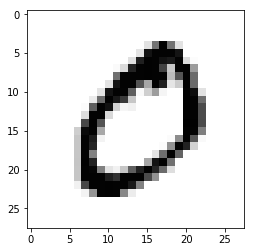

In [17]:
#Show the second image of the training dataset
plt.imshow(train_images[1],cmap='Greys')
plt.show()

In [91]:
class NeuralNetwork:
    def __init__(self,sizes):
        """
        This is the init method for the neural network which will be evaluating mnist using adaptive learning rates 
        and clr.
        The size of the neural network will be the length of the list sizes.
        for example if sizes is [2,3,1] it will be a 3 layered neural network with the first layer being the input layer
        and containing 2 neurons with a hidden layer of 3 neurons and an output layer of 1 neuron
        The bias and weights of the network will be initialized with a gaussian distribution with mean of zero and
        variance 1 basically np.random.rand :P
        
        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def sigmoid(z):
        """
        The sigmoid activation function
        """
        return 1.0/(1.0+np.exp(-z))
    def sigmoid_prime(z):
        """
        The derivative of sigmoid used in backpropagation
        """
        return sigmoid(z)*(1-sigmoid(z))
    def feedforward_nn(self,X):
        """
        This is the forward propagation function of the neural network.
        The equation is Input times weight, add a bias, activate.
        """
        for W,b in zip(self.weights,self.biases):
            
            Z = sigmoid(np.dot(W,x) + b)
        print(Z.shape) #verify the shape of Z
        return Z
    
    def get_triangularLR(iteration,stepSize,base_lr,max_lr):
        """
        Define the learning rate according to the CLR technique. Define the total no of iterations
        and vary the learning rate in between the iterations in 1 epoch
        """
        cycle = np.floor(1+iteration/2*stepSize)
        x = np.abs(iteration/stepsize - 2*cycle + 1)
        lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
        return lr
    
    def SGD(self,training_data,epochs,mini_batch_size):
        """
        Train the neural network using stochastic gradient descent.
        Divide the training_data passed into mini batches.
        For each mini_batch update the gradient and need to update the weights somewhere
        """
        n = len(training_data)
        stepsize = np.ceil(n/mini_batch_size)
        base_lr = 0.01
        max_lr = 0.08
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            
            #get_triangularCR
            for index,mini_batch in enumerate(mini_batches):
                iteration = index + (j-1)*stepsize
                lr = get_triangularLR(iteration,stepsize,base_lr,max_lr)
                self.update_mini_batch(mini_batch,lr)
            

    def backprop(self):
        """
        Backpropagate to update weights
        """
        pass
    def update_mini_batch(self,mini_batch,eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x,y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
        
        
        
    

In [92]:
def get_triangularLR(iteration,stepsize,base_lr,max_lr):
    cycle = np.floor(1+iteration/2*stepSize)
    print("cycle {}".format(cycle))
    x = np.abs(iteration/stepsize - 2*cycle + 1)
    print("x {}".format(x))
    #lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    print(np.maximum(0,(1-x)))
    return lr

In [89]:
num_iterations = 10
stepSize = 1
base_lr = 0.001
max_lr = 0.01
lr_trend = list()
for iteration in range(num_iterations):
    print(iteration)
    lr = get_triangularLR(iteration, stepSize, base_lr, max_lr)
    
    # Update your optimizer to use this learning rate in this iteration
    lr_trend.append(lr)



0
cycle 1.0
x 1.0
0.0
1
cycle 1.0
x 0.0
1.0
2
cycle 2.0
x 1.0
0.0
3
cycle 2.0
x 0.0
1.0
4
cycle 3.0
x 1.0
0.0
5
cycle 3.0
x 0.0
1.0
6
cycle 4.0
x 1.0
0.0
7
cycle 4.0
x 0.0
1.0
8
cycle 5.0
x 1.0
0.0
9
cycle 5.0
x 0.0
1.0


In [10]:
string = "This is fun !"
string[::-1]

'! nuf si sihT'

In [90]:
lr_trend

[0.001,
 0.010000000000000002,
 0.001,
 0.010000000000000002,
 0.001,
 0.010000000000000002,
 0.001,
 0.010000000000000002,
 0.001,
 0.010000000000000002]

In [30]:
sizes = [2,3,1]
weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

In [31]:
bias = [np.random.randn(y, 1) for y in sizes[1:]]

In [22]:
np.random.randn(3,1)

array([[-0.09863083],
       [-0.1345898 ],
       [ 0.96140015]])

In [43]:
bias

[array([[-0.1600541 ],
        [-0.73433089],
        [-0.14546473]]), array([[-0.53342218]])]

In [35]:
input = np.random.randn(2,1)

In [36]:
input

array([[-0.20653489],
       [-1.47811513]])

In [44]:
Z = weights[0].dot(input) + bias[0]

In [46]:
Z1 = []
for W,b in zip(weights,bias):
    Z1 = np.dot(W,input)+b
    

ValueError: shapes (1,3) and (2,1) not aligned: 3 (dim 1) != 2 (dim 0)

In [62]:
n = len(train_images)
training_data = []

In [63]:
mini_batches = [training_data[k:k+64] for k in range(0,n,64)]

In [64]:
len(mini_batches)

938

In [71]:
for index,mini_batch in enumerate(mini_batches):
    print(mini_batch)


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

In [70]:
np.ceil(60000/64)

938.0